# Figure4 <br />

### Step1: Run with STAR with options bellow <br />
* -readFilesCommand zcat --outFilterMultimapNmax 100 --winAnchorMultimapNmax 100 --outMultimapperOrder Random --runRNGseed 777 --outSAMmultNmax 1 --outSAMtype BAM Unsorted --twopassMode Basic --outFilterType BySJout --alignSJoverhangMin 8 --alignSJDBoverhangMin 1 --outFilterMismatchNmax 999 --alignIntronMin 20 --alignIntronMax 1000000 --alignMatesGapMax 1000000 
---

### Step2: Run with scTE with options bellow <br />
* -p 4 -CB False -UMI False --genome mm10 -x mm10.exclusive.idx
---

### Step3: Processing with scanpy pipeline <br />

In [1]:
import scanpy as sc
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import colors
import seaborn as sb
from gprofiler import gprofiler
import glob,os

import logging,matplotlib,os,sys

from rpy2.robjects import pandas2ri

pandas2ri.activate()
%load_ext rpy2.ipython

plt.rcParams['figure.figsize']=(6,6) 
sc.settings.verbosity = 1
sc.set_figure_params(dpi=200, dpi_save=600)
sc.logging.print_versions()

matplotlib.rcParams['pdf.fonttype']=42
matplotlib.rcParams['font.size']=10

os.getcwd()
os.chdir('/public/home/jphe/rnaseq/mouse/scRNA/C1/GSE109774/zscanpy')
os.getcwd()

/public/home/jphe/anaconda3/envs/scanpy/lib/python3.6/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


scanpy==1.4.4 anndata==0.6.22.post1 umap==0.3.10 numpy==1.16.4 scipy==1.3.1 pandas==0.25.0 scikit-learn==0.19.2 statsmodels==0.10.1 python-igraph==0.7.1 louvain==0.6.1


'/public/home/jphe/rnaseq/mouse/scRNA/C1/GSE109774/zscanpy'

In [2]:
import glob,os

i=0
for f in sorted(glob.glob('data/*.tsv')): # the tsv file was outputed by scTE
    head = os.path.split(f)[1].replace('.tsv','')
    print(head)
    
    tmp= sc.read(f,cache=False)
    tmp.obs['time'] =head
    sc.pp.filter_cells(tmp, min_genes = 1000)
    sc.pp.filter_cells(tmp, min_counts = 50000)
    
    if len(tmp) > 4000:
        sc.pp.subsample(tmp, n_obs= 4000 )
    
    i+=1
    if i==1:
        adata = tmp.copy()
    else:
        adata = adata.concatenate([tmp])
        
adata.obs.index = [k.split('-')[0] for k in adata.obs.index]
genenames = [name for name in adata.var_names if ')n' not in name]
adata=adata[:,genenames]
adata

Bladder
Brain_Microglia
Brain_Neurons
Colon
Fat
Heart
Kidney
Liver
Lung
Mammary
Marrow
Muscle
Pancreas
Skin
Spleen
Thymus
Tongue
Trachea


View of AnnData object with n_obs × n_vars = 55725 × 56421 
    obs: 'batch', 'n_counts', 'n_genes', 'time'

In [3]:
sc.pp.filter_genes(adata, min_cells=200)
print('Number of genes after cell filter: {:d}'.format(adata.n_vars))

Trying to set attribute `.var` of view, making a copy.


Number of genes after cell filter: 55812


... storing 'time' as categorical


good box


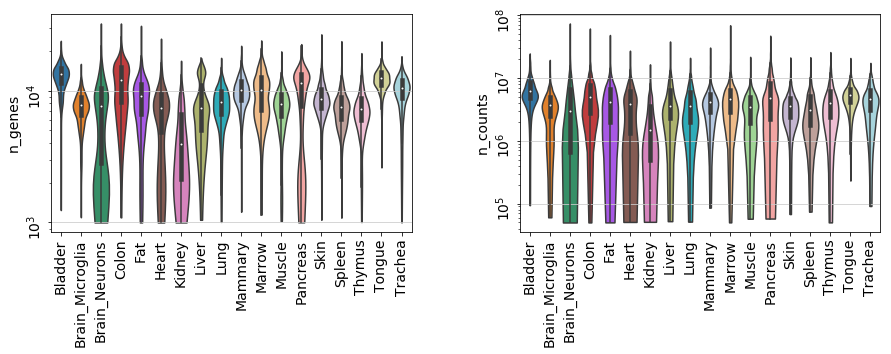

In [4]:
adata.X = adata.X.astype('float64')
adata.obs['n_counts'] = adata.X.sum(1)
adata.obs['log_counts'] = np.log(adata.obs['n_counts'])
adata.obs['n_genes'] = (adata.X > 0).sum(1)

mt_gene_mask = [gene.startswith('mt') for gene in adata.var_names]
adata.obs['mt_frac'] = adata.X[:, mt_gene_mask].sum(1)/adata.obs['n_counts']

t1 = sc.pl.violin(adata, ['n_genes','n_counts'], groupby='time', size=1, log=True, cut=0,stripplot=False,rotation=90)

In [5]:
sc.pp.filter_cells(adata, min_counts = 5e5)
sc.pp.filter_cells(adata, max_counts = 2e7)

In [6]:
adata_pp = adata.copy()
sc.pp.normalize_per_cell(adata_pp, counts_per_cell_after=1e6)
sc.pp.log1p(adata_pp)
sc.pp.pca(adata_pp, n_comps=15,svd_solver='arpack')
sc.pp.neighbors(adata_pp)
sc.tl.louvain(adata_pp, key_added='groups', resolution=0.5)

input_groups = adata_pp.obs['groups']
data_mat = adata.X.T

In [7]:
%%R -i data_mat -i input_groups -o size_factors
require(scran)

size_factors = computeSumFactors(data_mat, clusters=input_groups, min.mean=0.1)

R[write to console]: Loading required package: scran

R[write to console]: Loading required package: SingleCellExperiment

R[write to console]: Loading required package: SummarizedExperiment

R[write to console]: Loading required package: GenomicRanges

R[write to console]: Loading required package: stats4

R[write to console]: Loading required package: BiocGenerics

R[write to console]: Loading required package: parallel

R[write to console]: 
Attaching package: ‘BiocGenerics’


R[write to console]: The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


R[write to console]: The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


R[write to console]: The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    d

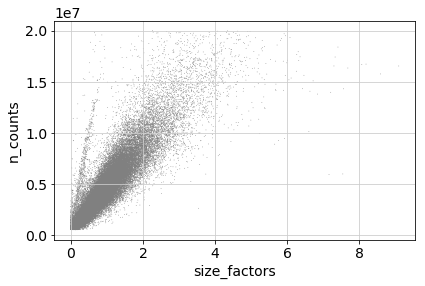

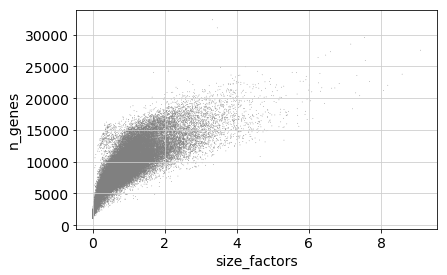

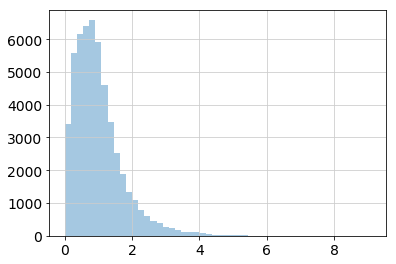

In [8]:
del adata_pp
adata.obs['size_factors'] = size_factors
sc.pl.scatter(adata, 'size_factors', 'n_counts')
sc.pl.scatter(adata, 'size_factors', 'n_genes')
sb.distplot(size_factors, bins=50, kde=False)
plt.show()
adata.layers["counts"] = adata.X.copy()
adata.X /= adata.obs['size_factors'].values[:,None]
sc.pp.log1p(adata)
adata.raw = adata


 Number of highly variable genes: 4000


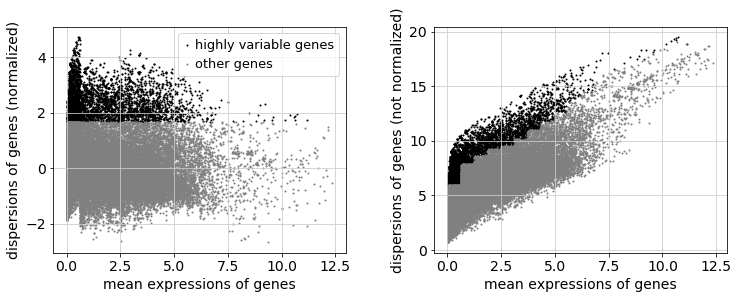

Only considering the two last: ['.scran', '.h5ad'].
Only considering the two last: ['.scran', '.h5ad'].


In [9]:
sc.pp.highly_variable_genes(adata, n_top_genes=4000)
print('\n','Number of highly variable genes: {:d}'.format(np.sum(adata.var['highly_variable'])))
sc.pl.highly_variable_genes(adata)
sc.pp.pca(adata, n_comps=50, use_highly_variable=True, svd_solver='arpack')
sc.pp.neighbors(adata)
sc.tl.tsne(adata, n_jobs=20) 
sc.tl.umap(adata)
sc.tl.leiden(adata, key_added='leiden_r1')
sc.tl.leiden(adata, resolution=0.5, key_added='leiden_r0.5')
sc.tl.leiden(adata, resolution=0.1, key_added='leiden_r0.1')
adata.obs['leiden_r0.5'].value_counts()
adata.write("write/18organ.C1.scTEs.scran.h5ad")
adata = sc.read("write/18organ.C1.scTEs.scran.h5ad")

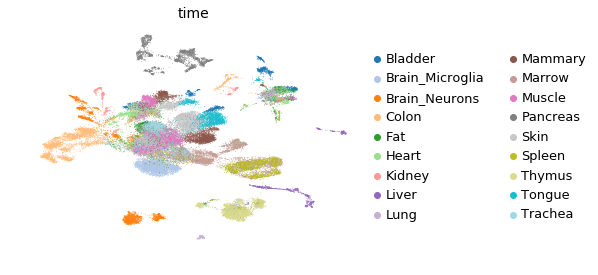

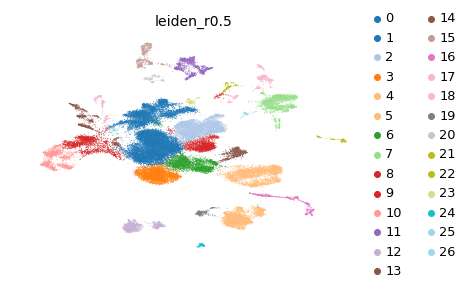

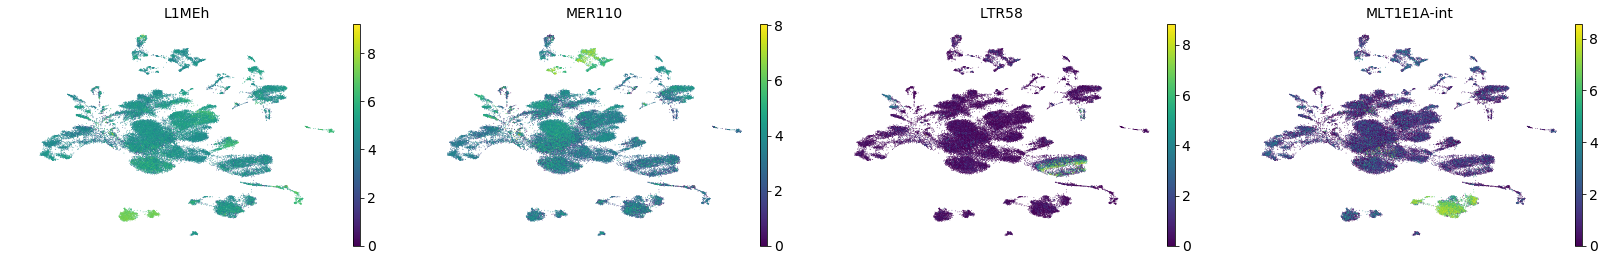

In [10]:
sc.pl.umap(adata, color =['time'], frameon=False, palette='tab20')
sc.pl.umap(adata, color =['leiden_r0.5'], frameon=False, palette='tab20')
sc.pl.umap(adata, color =['L1MEh','MER110','LTR58','MLT1E1A-int'], frameon=False, palette='tab20')

In [11]:
df=pd.read_table('/public/home/jphe/omicsdata/genome/mm10/scTE/atac/tename.txt',header=None)
tename=list(df[0])
tename = [k for k in tename if k in adata.var.index]
te = adata[:, tename]

sc.tl.rank_genes_groups(te,'leiden_r0.5', n_genes=50,method = 't-test', use_raw=False)
sc.logging.print_memory_usage()
groups = te.uns['rank_genes_groups']['names'].dtype.names
df=pd.DataFrame( {group + '_' + key[:1]: te.uns['rank_genes_groups'][key][group]  for group in groups for key in ['names','logfoldchanges','pvals']})
df.to_csv('write/ranktes.te.r0.5.tsv',sep='\t')

Memory usage: current 209.50 GB, difference +209.50 GB


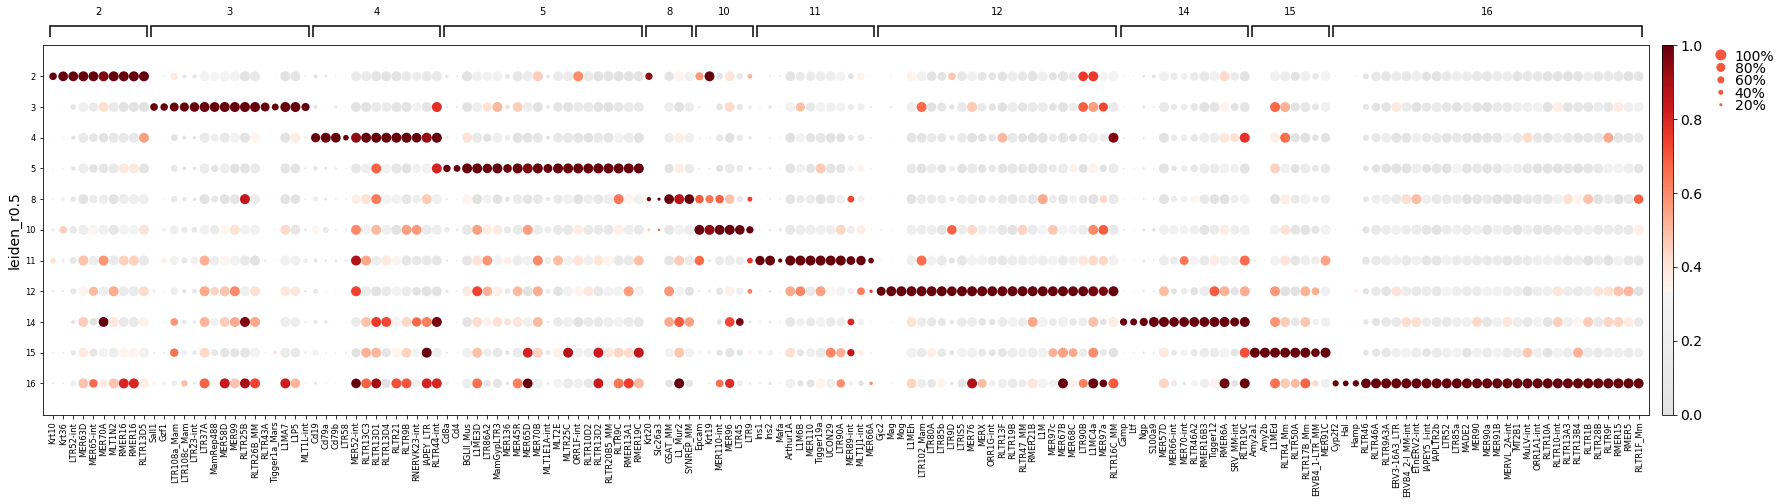

GridSpec(2, 5, height_ratios=[0.5, 10], width_ratios=[29.05, 0, 0.2, 0.5, 0.25])

In [12]:
marker_tes = {
    '2' : ['Krt10','Krt36', 'LTR52-int','MER63D','MER65-int','MER70A', 'MLT1N2', 'RMER16','RMER16','RLTR13D5', ],
    '3' : ['Sall1','Gzf1', 'LTR108a_Mam', 'LTR108c_Mam',  'LTR23-int', 'LTR37A','MamRep488','MER58D',  'MER99', 
         'RLTR25B','RLTR26B_MM','RLTR43A', 'Tigger1a_Mars', 'L1MA7', 'L1P5', 'MLT1L-int', ], 
    '4' : [ 'Cd19','Cd79a','Cd79b', 'LTR58', 'MER52-int', 'RLTR13C3', 'RLTR13D1', 'RLTR13D4','RLTR21','RLTR9B','RNERVK23-int', 'IAPEY_LTR',  'RLTR44-int',  ], 
    '5' : ['Cd8a','Cd4', 'BGLII_Mus', 'L1ME3D', 'LTR86A2','MamGypLTR3','MER136', 'MER45R', 'MER65D','MER70B','MLT1E1A-int','MLT2E', 'MLTR25C','ORR1F-int', 
           'RLTR10D2','RLTR13D2','RLTR20B5_MM','RLTR9C','RMER13A1','RMER19C', ],    
    '8' : ['Krt20','Slc26a3', 'GSAT_MM', 'L1_Mur2','SYNREP_MM',],
    '10': ['Epcam','Krt19', 'MER110-int','MER96','LTR45', 'LTR9', ],
    '11': ['Ins1','Ins2','Mafa', 'Arthur1A', 'L1M6B', 'MER110', 'Tigger19a','UCON29','LTR90A', 'MER89-int', 'MLT1J1-int', 'MER66A',  ], 
    '12': ['Gjc2','Mag','Mog', 'L1MEh', 'LTR102_Mam','LTR80A', 'LTR85b','LTR9D','LTRIS5', 'MER76','MERX','ORR1G-int','RLTR13F','RLTR19B','RLTR47_MM','RMER21B',
          'L1M','MER97c', 'MER67B', 'MER68C','LTR90B','L1MC4a', 'MER97a', 'RLTR16C_MM', ],
    '14': ['Camp','Ltf','Ngp','S100a9', 'MER57D','MER66-int', 'MER70-int','RLTR46A2','RMER16B3','Tigger12','RMER6A','SRV_MM-int', 'RLTR19C'],
    '15': ['Amy2a1','Amy2b', 'L1MEd', 'RLTR4_Mm','RLTR50A','RLTR17B_Mm','ERVB4_1-LTR_MM','MER91C', ], 
    '16': ['Cyp2f2','Hal','Hamp',  'RLTR46','RLTR46A','RLTR9A3A', 'ERV3-16A3_LTR', 'ERVB4_2-I_MM-int', 'ETnERV2-int',  'IAPEY5_I-int', 'IAPLTR2b','LTR52', 'LTR85a', 'MADE2', 'MER90',
           'MER90a', 'MER91B','MERVL_2A-int', 'MT2B1', 'MuLV-int', 'ORR1A1-int','RLTR10A','RLTR10-int','RLTR13A3', 'RLTR13B4', 'RLTR1B', 'RLTR28B',
           'RLTR9F','RMER15','RMER5','RLTR1F_Mm',  ], 
        }
from matplotlib.colors import ListedColormap
from matplotlib.colors import LinearSegmentedColormap

colors1 = plt.cm.Greys_r(np.linspace(0.8,0.9,50))
colors2 = plt.cm.Reds(np.linspace(0.0, 1, 100))
colorsComb = np.vstack([colors1, colors2])
mymap = colors.LinearSegmentedColormap.from_list('my_colormap', colorsComb)

sliced = [ k for k in adata.obs.index if adata.obs['leiden_r0.5'][k] in marker_tes.keys()]
sliced = adata[sliced,]
sc.pl.dotplot(sliced, marker_tes, groupby='leiden_r0.5', standard_scale='var', expression_cutoff=0, dendrogram=False, color_map = mymap, use_raw = False,figsize=[30,7])